# Binary classification test

In [45]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
import seaborn as sns

## Introduction



```
# This is formatted as code
```

Binary predictors are a key tool in classification problems. These predictors are central to a variety of applications, from disease diagnosis to financial forecasting. In this computer lab, we will attempt to assess the quality of a set of binary predictors on balanced and unbalanced datasets using the quality estimators and metrics we defined in the previous class.

## Experimental setup

We will create an artificial dataset with two clusters in high dimensions. We will assign a label 0 and 1 to each of these clusters and the goal is to evaluate the performance of different predictors to classify which entry belongs to each cluster. In the lab, we will firstly evaluate the quality of the predictions and secondly fine tune the parameters to optimize the performance of each predictor. In the end, we will decide which predictor is the best of all.

We plan to study the following predictors:

#### 1. Random assignment

- **Strategy:** Randomly assign label 1 based on a predefined probability \( p \).
- **Parameter to Tune:** The probability \( p \) of choosing label 1.

#### 2. PCA-based predictor

- **Strategy:** Use principal component analysis (PCA) to assign label 1 based on the first principal component (PC1).
- **Parameter to Tune:** The threshold \( a \) so that label 1 is selected when PC1 < \( a \).

#### 3. Logistic Regression

- **Strategy:** Implement logistic regression to estimate the probability that a given entry belongs to label 1.
- **Tuning parameter:** The threshold for determining the label based on the estimated probability.

---

## Next steps:

1. Define our data set
2. Define the different predictors
3. Define the various quality metrics discussed in the previous class.
4. Evaluate each predictor and optimize the parameters



## 1. Generation of our dataset

We generate 2 random clusters for a binary test classification

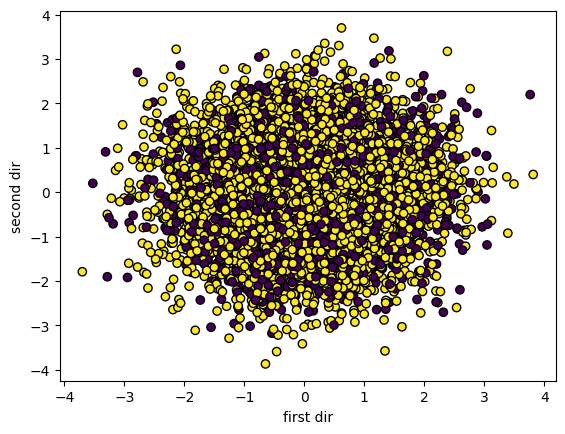

In [46]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Setting the probability for the true class
Prob_true = 0.7

# Generating the n_samples in 20 dimensions belonging to 2 categories
X, y = make_classification(n_features=20,
                           n_samples=10000,
                           n_classes=2,
                           # n_clusters_per_class=1,
                           # class_sep=1.5,
                           weights=[1 - Prob_true, Prob_true],
                           random_state=0
                           )

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2)

# Plotting the generated data
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, edgecolors='k')
plt.xlabel('first dir')
plt.ylabel('second dir')
plt.show()

We can check that there are two clases of data-points using dimensional reduction, for instance the PCA (we will study its meaning later on in the course)

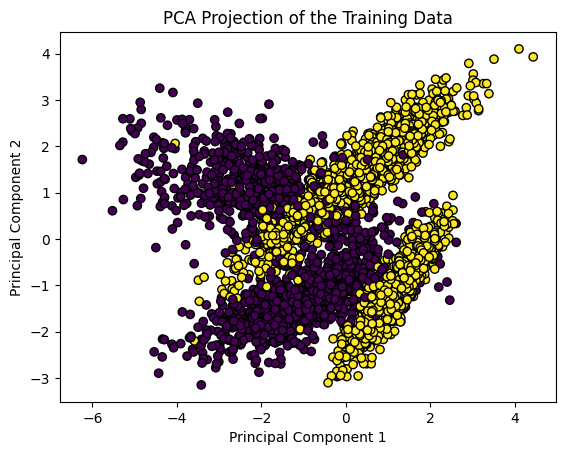

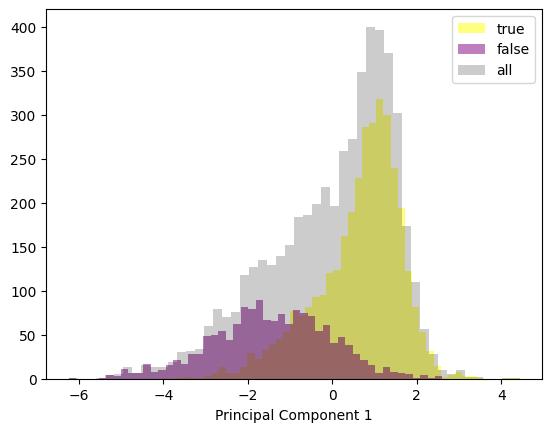

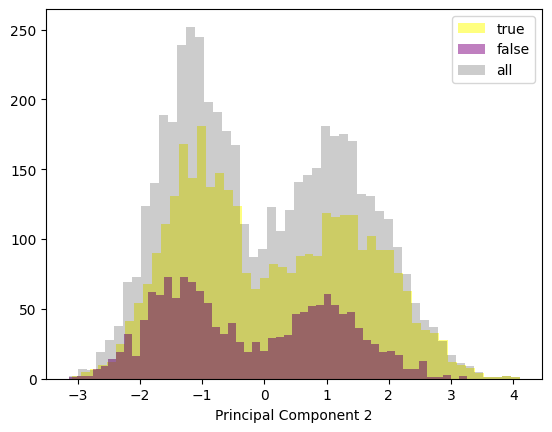

In [47]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# Plotting the training data in the new PCA space
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], marker='o', c=y_train, edgecolors='k')
plt.title('PCA Projection of the Training Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

index_1 = (y_train == 1)
index_0 = (y_train == 0)

plt.hist(X_train_pca[index_1, 0], bins=50, color='yellow', alpha=0.5, label='true')
plt.hist(X_train_pca[index_0, 0], bins=50, color='purple', alpha=0.5, label='false')
plt.hist(X_train_pca[:, 0], bins=50, color='black', alpha=0.2, label='all')
plt.legend()
plt.xlabel('Principal Component 1')
plt.show()

plt.hist(X_train_pca[index_1, 1], bins=50, color='yellow', alpha=0.5, label='true')
plt.hist(X_train_pca[index_0, 1], bins=50, color='purple', alpha=0.5, label='false')
plt.hist(X_train_pca[:, 1], bins=50, color='black', alpha=0.2, label='all')
plt.legend()
plt.xlabel('Principal Component 2')
plt.show()

## 2. Define different predictors

We need to define our 3 different predictors.

### No skills

The first predictor is a random guess. We will assign the label 1 to each entry with a probability \( p \).

In [48]:
def no_skills(X, p=0.5):
    return (np.random.rand(len(X)) < p).astype(int) # return a random guess

### Naive: PCA based predictor

The second predictor is based on the first principal component. We will assign the label 1 to each entry with a value of the first principal component smaller than a given threshold.

In [49]:
def PCA_based(X, threshold):
    pca = PCA(n_components=1)
    X_pca = pca.fit_transform(X).reshape(len(X))
    return (X_pca < threshold).astype(int)

### Training: Logistic regression

We can learn to classify this data using logistic regression. I include a discussion about its training, but we do not need this for this lab.

Let us describe the data in terms of a probability function
$$p_{A,B}(\boldsymbol{x})=\frac{1}{1+e^{-(A+\boldsymbol{B}\cdot\boldsymbol{x})}},$$ using labeled data $(\boldsymbol{x}_k,y_k)$. We want to train the model such that the probability $p_k=p_{A,B}(\boldsymbol{x}_k)=1$ for $y_k=1$ and 0 for $y_k=0$. For this purpose, we can define a log loss
$$L=-\sum_{k} y_k\log p_k -(1-y_k)\log p_k $$
(it is clear that $L$ is minimized $p_k=1$ when $y_k=1$ and $p_k=0$ when $y_k=0$).
One can then minimize it by calculating the gradient
$$\frac{\partial L}{\partial A}=\sum_k (p_k-y_k)=0$$
$$\frac{\partial L}{\partial \boldsymbol{B}}=\sum_k \boldsymbol{x}_k (p_k-y_k)=0$$
Which is solved numerically. As a result of this process, we obtain a way to assign to each data point a probability of being in the category $y=1$.

In [50]:
from sklearn.linear_model import LogisticRegression


def logistic(X_test, X_train, y_train, p=0.5):
    clf = LogisticRegression(solver='lbfgs', max_iter=1000)
    clf.fit(X_train, y_train)

    # ".predict_proba" is needed instead of ".predict" to check the quality as a function of p (for exercise 5)
    proba = clf.predict_proba(X_test)[:, 1]
    return (proba >= p).astype(int)

## 3. Confusion matrix

Now we have a set of two pairs mutually incompatible events:

- **True cluster** being part of cluster $[0,1]$,
- **Predicted label**: getting $[-,+]$


### Confusion matrices

We need to compute the conditional probablities $P(0|+)$, $P(1|+)$, $P(0|-)$, $P(1|-)$, and the joint probabilities $P(0\cap +)$, $P(1\cap +)$, $P(0\cap -)$, $P(1\cap -)$.

The confusion matrix is a table that is often used to describe the performance of a classification model on a set of data for which the true values are known. The confusion matrix is a 2x2 table with counts of the following events:

- **True Negative (TN)**: The number of correct predictions that an entry is in the negative class.
- **False Positive (FP)**: The number of incorrect predictions that an entry is in the positive class.
- **False Negative (FN)**: The number of incorrect predictions that an entry is in the negative class.
- **True Positive (TP)**: The number of correct predictions that an entry is in the positive class.

We can visualize the confusion matrix as follows:

<table>
    <tr>
        <th></th>
        <th>Pred -</th>
        <th>Pred +</th>
    </tr>
    <tr>
        <th>Real 0</th>
        <td>TN</td>
        <td>FP</td>
    </tr>
    <tr>
        <th>Real 1</th>
        <td>FN</td>
        <td>TP</td>
    </tr>
</table>

**Exercise**: Write a function to compute the entries of the confusion matrix

In [51]:
def compute_confusion_matrix(y_test, y_pred):
    # assign unique int to each case with 2 * y_test + y_pred and count number of occurences with np.bincount:
    # TN = 2 * 0 + 0 = 0
    # FP = 2 * 0 + 1 = 1
    # FN = 2 * 1 + 0 = 2
    # TP = 2 * 1 + 1 = 3
    TN, FP, FN, TP = np.bincount(2 * y_test + y_pred, minlength=4)
    return TN, FP, FN, TP

It is more convenient to divide by the total number of entries to have an idea of the proportions of each case.

<table>
  <tr>
    <th></th>
    <th>Pred -</th>
    <th>Pred +</th>
  </tr>
  <tr>
    <th>Real 0</th>
    <td>TNR </td>
    <td>FPR </td>
  </tr>
  <tr>
    <th>Real 1</th>
    <td>FNR </td>
    <td>TPR</td>
  </tr>
</table>

Such matrix represents the joint probabilities of the events. Here, the letter R stands for ratio, i.e. the proportion of each case. (It is different from the specificity and sensitivity, also called true negative rate and true positive rate, which are conditional probabilities).

**Exercise**:
1. Display the normalized confusion matrix for each of the predictors.
2. Based on the confusion matrices, which predictor is the best? Which predictor is the worst?
3. Considering the random classifier as a *Model baseline*, what can you say about the quality of the two other predictors?

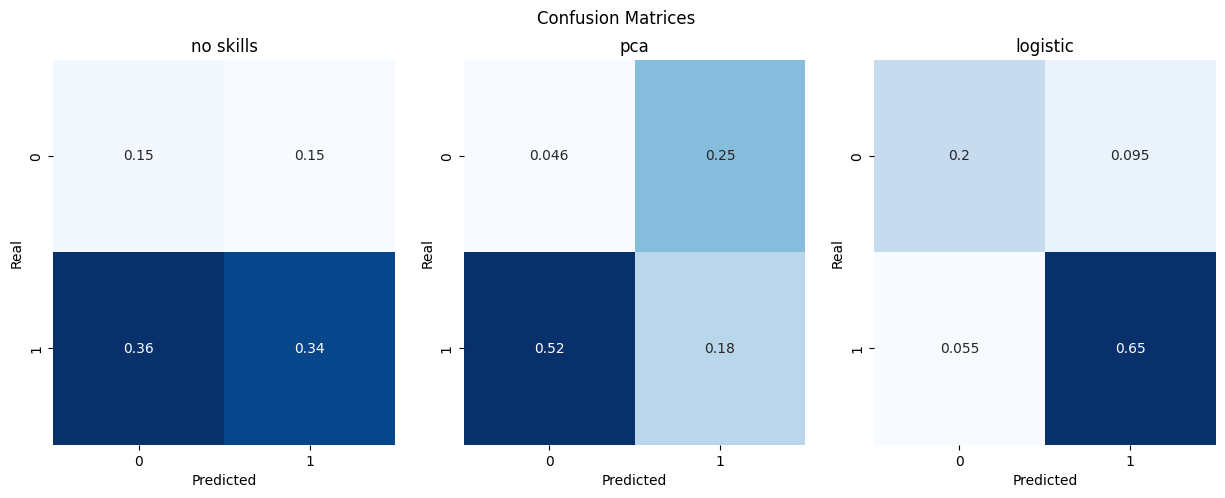

In [52]:
y_pred_r = no_skills(X_test) # no skills
y_pred_pca = PCA_based(X_test, threshold=0) # pca prediction with threshold 0

y_pred_l = logistic(X_test, X_train, y_train) # logistic regression

titles = ['no skills', 'pca', 'logistic']
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, y_pred in enumerate([y_pred_r, y_pred_pca, y_pred_l]):
    TN, FP, FN, TP = compute_confusion_matrix(y_test, y_pred)

    cm = np.array([[TN, FP], [FN, TP]])
    normalized_cm = cm / np.sum(cm)

    ax[i].set_title(titles[i])
    sns.heatmap(cm / np.sum(cm), annot=True, cmap="Blues", cbar=False, ax=ax[i])
    ax[i].set_xlabel('Predicted')
    ax[i].set_ylabel('Real')
plt.suptitle('Confusion Matrices')
plt.show()

2. The best predictor is the logistic model. The worst predictor is the "no skills" model.
The "no skills" model's true negatives are 0.15 and false positives are 0.15. False negatives are 0.36 and true positives are 0.34. This means the model is getting it right about as often as getting it wrong which is the same as random guessing.
The PCA model has very low true negatives (0.046) and high false negatives (0.52). It makes more mistakes (FP, FN) than correct predictions (TN, TP). The PCA model is getting it wrong more often than right so it's worse than random guessing.
The logistic regression model has high true positives (0.65) and good true negatives (0.2). It doesn't make a lot of mistakes (FP = 0.095, FN = 0.055). The model is getting it right most of the time so it makes good predictions.

3. PCA's true positives (0.18) are lower than the baseline (0.34). Its true negatives (0.046) are also lower than the baseline (0.15). This means it makes more false predictions than the baseline and it performs worse than random guessing.
The logistic regression model's true positives (0.65) are much higher than the baseline (0.34) and the true negatives (0.20) are also higher than the baseline (0.15). Its false predictions are much lower than the baseline. There is a clear improvement over random guessing.




## Random confusion matrix

The random confusion matrix is a special case where the events are assumed to be independent. It is a baseline metric that can be used to evaluate the extent to which the predictors make use of the information in the dataset.

Remember that the independence of events implies the following equalities:

$P(0 \cap +) = P(0)P(+)$

$P(1 \cap +) = P(1)P(+)$

$P(0 \cap -) = P(0)P(-)$

$P(1 \cap -) = P(1)P(-)$

Therefore, the corresponding confusion matrix is:

<table>
  <tr>
    <th></th>
    <th>Pred -</th>
    <th>Pred +</th>
  </tr>
  <tr>
    <th>Real 0</th>
    <td>𝑃(0)𝑃(-)</td>
    <td>𝑃(0)𝑃(+)</td>
  </tr>
  <tr>
    <th>Real 1</th>
    <td>𝑃(1)𝑃(-)</td>
    <td>𝑃(1)𝑃(+)</td>
  </tr>
</table>

**Exercise**: Write a function to compute the random confusion matrix.

In [53]:
def compute_randomconfusion_matrix(y_test, y_pred):
    # p_real = [P(0), P(1)] and p_pred = [P(-), P(+)]
    p_real, p_pred = np.bincount(y_test, minlength=2) / len(y_test), np.bincount(y_pred, minlength=2) / len(y_test)
    
    # compute outer product to get all combinations: [[P(0)P(-), P(0)P(+)], [P(1)P(-), P(1)P(+)]]
    # multiply by length and reshape to 2x2 matrix to get TN, FP, FN and TP
    return np.round(np.outer(p_real, p_pred) * len(y_test)).reshape(2, 2).astype(int)

**Exercise**: Display the normalized confusion matrix for each of the predictors.

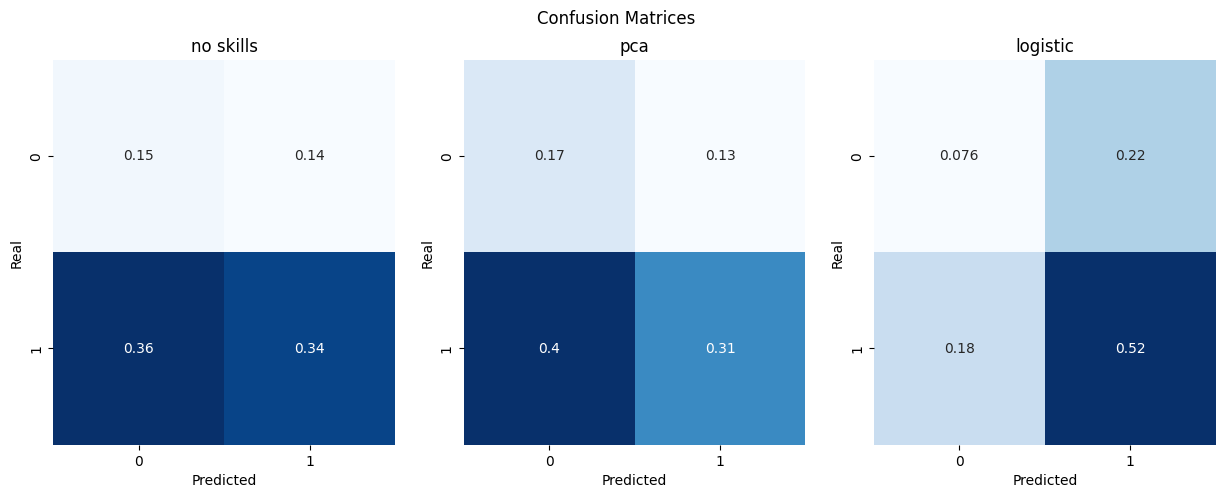

In [54]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, y_pred in enumerate([y_pred_r, y_pred_pca, y_pred_l]):
    cm = compute_randomconfusion_matrix(y_test, y_pred)
    normalized_cm = cm / np.sum(cm)

    ax[i].set_title(titles[i])
    sns.heatmap(normalized_cm, annot=True, cmap="Blues", cbar=False, ax=ax[i])
    ax[i].set_xlabel('Predicted')
    ax[i].set_ylabel('Real')
plt.suptitle('Confusion Matrices')
plt.show()

**Exercise**: Comparing the random confusion matrix with the confusion matrix of the predictors, what predictor makes best use of the information in the dataset? Which makes the worst use of the information?

For the "no skills" model the values are almost identical so it makes no use of dataset information (as expected for random classifier).
The PCA model's values deviate from random, but in the wrong direction. True predictions (TN = 0.04, TP = 0.18) are lower than random (TN = 0.17, TP = 0.31) so it makes negative use of information (worse than ignoring it).
For the logistic regression model the true positives (0.65) are higher than random (0.52) and the true negatives (0.2) are higher than random chance (0.076). This means that i makes best use of information to improve the predictions.

## 4. Quality estimators

We can define a set of quality metrics to evaluate the performance of the predictors. These metrics are:

- **Sensitivity (Recall)**: The proportion of actual positive cases that were correctly predicted.
- **Specificity**: The proportion of actual negative cases that were correctly predicted.
- **Precision**: The proportion of predicted positive cases that were correctly predicted.
- **Negative Predictive Value (NPV)**: The proportion of predicted negative cases that were correctly predicted.
- **Accuracy**: The proportion of correct predictions.
- **F1 Score**: The harmonic mean of precision and sensitivity.

**Exercise**:
1. Give a closed-form expression for each of the quality metrics.
2. Define a function to compute each of the quality metrics.
3. Compute the quality metrics for each of the predictors.

### Closed-form expressions:

1. **Sensitivity (Recall)**:

   $$\text{Sensitivity} = \frac{TP}{TP + FN}$$

2. **Specificity**:

   $$\text{Specificity} = \frac{TN}{TN + FP}$$

3. **Precision**:

   $$\text{Precision} = \frac{TP}{TP + FP}$$

4. **Negative Predictive Value (NPV)**:

   $$\text{NPV} = \frac{TN}{TN + FN}$$

5. **Accuracy**:

   $$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$

6. **F1 Score**:

   $$\text{F1 Score} = \frac{2 \times \text{Precision} \times \text{Sensitivity}}{\text{Precision} + \text{Sensitivity}} = \frac{2 \times TP}{2 \times TP + FP + FN}$$


In [55]:
def calculate_metrics(TN, FP, FN, TP):
    def safe_div(n, d): return n / d if d > 0 else 0
    
    Sen = safe_div(TP, TP + FN)
    Spe = safe_div(TN, TN + FP)
    Pre = safe_div(TP, TP + FP)
    NPV = safe_div(TN, TN + FN)
    Acc = safe_div(TP + TN, TP + TN + FP + FN)
    F1 = safe_div(2 * Pre * Sen, Pre + Sen)

    return Sen, Spe, Pre, NPV, Acc, F1

In [56]:
def metrics(y_test, y_pred):
    TN, FP, FN, TP = compute_confusion_matrix(y_test, y_pred)
    
    Sen, Spe, Pre, NPV, Acc, F1 = calculate_metrics(TN, FP, FN, TP)

    return Sen, Spe, Pre, NPV, Acc, F1

In [57]:
def metrics_baseline(y_test, y_pred):
    cm = compute_randomconfusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = cm.flatten()
    
    Sen_ran, Spe_ran, Pre_ran, NPV_ran, Acc_ran, F1_ran = calculate_metrics(TN, FP, FN, TP)

    return Sen_ran, Spe_ran, Pre_ran, NPV_ran, Acc_ran, F1_ran

In [58]:
def quality_estimators(y_test, y_pred):
    Sen, Spe, Pre, NPV, Acc, F1 = metrics(y_test, y_pred)
    Sen_ran, Spe_ran, Pre_ran, NPV_ran, Acc_ran, F1_ran = metrics_baseline(y_test, y_pred)

    print("**********************")

    print(f"{'Accuracy:':<25} {Acc * 100:.2f}% ({Acc_ran * 100:.2f}%)")
    print(f"{'F1 Score:':<25} {F1:.2f} ({F1_ran:.2f})")
    print(f"{'Sensitivity (Recall):':<25} {Sen * 100:.2f}% ({Sen_ran * 100:.2f}%)")
    print(f"{'Precision:':<25} {Pre * 100:.2f}% ({Pre_ran * 100:.2f}%)")
    print(f"{'Specificity:':<25} {Spe * 100:.2f}% ({Spe_ran * 100:.2f}%)")
    print(f"{'NPV:':<25} {NPV * 100:.2f}% ({NPV_ran * 100:.2f}%)")

    print("**********************")


In [59]:
for i, y_pred in enumerate([y_pred_r, y_pred_pca, y_pred_l]):
    print(titles[i])
    quality_estimators(y_test, y_pred)


no skills
**********************
Accuracy:                 49.38% (49.54%)
F1 Score:                 0.58 (0.58)
Sensitivity (Recall):     48.73% (48.85%)
Precision:                70.19% (70.35%)
Specificity:              50.91% (51.18%)
NPV:                      29.52% (29.67%)
**********************
pca
**********************
Accuracy:                 23.02% (47.30%)
F1 Score:                 0.32 (0.54)
Sensitivity (Recall):     26.13% (43.39%)
Precision:                42.35% (70.32%)
Specificity:              15.64% (56.57%)
NPV:                      8.20% (29.65%)
**********************
logistic
**********************
Accuracy:                 85.00% (59.88%)
F1 Score:                 0.90 (0.72)
Sensitivity (Recall):     92.12% (74.27%)
Precision:                87.26% (70.35%)
Specificity:              68.11% (25.76%)
NPV:                      78.48% (29.68%)
**********************


**Exercise**:
1. Based on the quality metrics, which predictor is the best? Which predictor is the worst?
2. Considering the random classifier as a *Model baseline*, what can you say about the quality of the two other predictors?
3. Based on the quality metrics and the random quality metrics, which predictor makes the best use of the information in the dataset? Which makes the worst use of the information?

1. The best predictor is logistic regression. The worst predictor is PCA. Logistic regression's accuracy is 85% which is significantly higher than the other models' accuracy. Also its F1 score, sensitivity (recall), precision, specificity and negative predictive value (NPV) are significantly higher which confirms that it's the best model. PCA's accuracy is 23.02% which is much lower than the other models' accuracy. Also its other quality metrics (F1 score, sensitivity (recall), precision, specificity and negative predictive value) are significantly lower than the metrics of the logistic regression and the "no skills" models which confirms that the PCA model is the worst among the three predictors.

2. Logistic regression's performance surpasses the random classifier's performance by a lot. It achieves high accuracy which means it captures meaningful patterns in the data, F1 score and sensitivity (recall) are both higher which suggests that the logistic regression model is particularly strong in detecting positive cases without sacrificing precision. The other quality metrics also show better performance compared to the random classifier. The PCA model achieves low accuracy (23.02%) compared to the random classifier's accuracy (47.3%) which indicates that it doesn't utilize data patterns very well. The F1 score, sensitivity (recall), specificity, NPV and precision are also very low compared to the random classifier's metrics which means that the model is having problems with both true positive and true negative predictions.

3. The logistic regression model makes the best use of information in the dataset because there is a huge improvement in its quality metrics compared to its random quality metrics. This shows its ability to extract useful information, to learn and apply meaningful patterns from the data. On the other hand, the PCA model doesn't leverage useful data patterns effectively. Its performance is even worse than the random classifier's performance. Its low metrics show that dimensionality reduction may have removed critical information, leading to these weak predictions. And the "no skills" model makes no use of the information in the dataset (its quality metrics are basically the same as its random quality metrics).

## 5. Quality as a function of the parameters

Compute the accuracy of each method as function of the parameters of the predictor. What can you say about the quality of the predictors as a function of the parameters?

**Exercise**:
1. Compute the metrics of each method as a function of the parameters of the predictor.
2. Plot the metrics of each method as a function of the parameters of the predictor.
3. Based on the plot, which predictor is the best? Which predictor is the worst?
4. What can you say about the quality of the predictors as a function of the parameters?

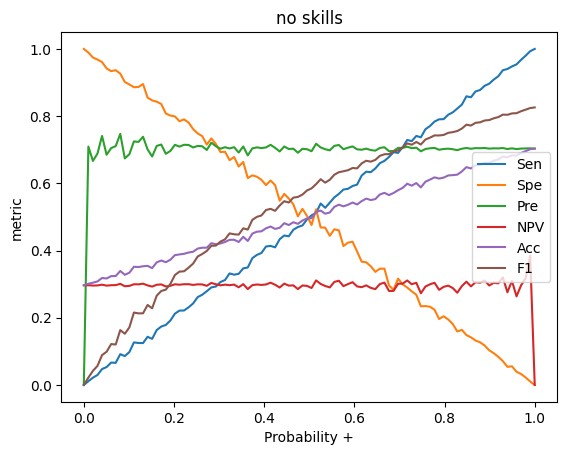

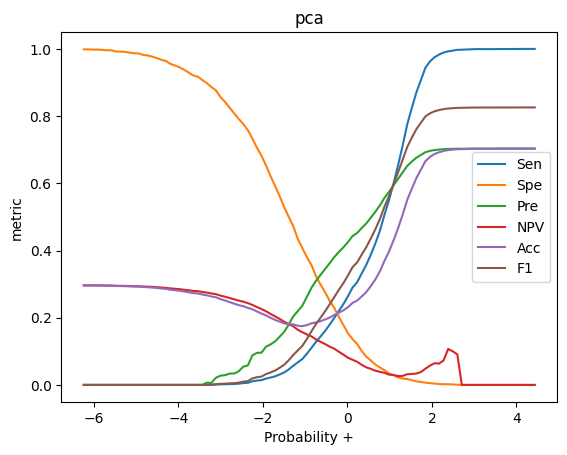

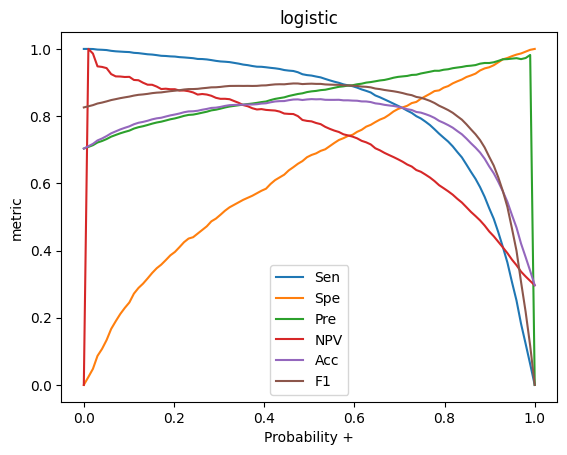

In [60]:
N = 100  # number of parameters

## random

range_noskill = np.linspace(0, 1, N)
Metrics_noskill = np.zeros((N, 6))
for ith, p in enumerate(range_noskill):
    y_pred_th = no_skills(X_test, p=p) # no skills
    Metrics_noskill[ith] = np.nan_to_num(metrics(y_test, y_pred_th))

plt.title(titles[0])
plt.plot(range_noskill, Metrics_noskill[:, 0], label='Sen')
plt.plot(range_noskill, Metrics_noskill[:, 1], label='Spe')
plt.plot(range_noskill, Metrics_noskill[:, 2], label='Pre')
plt.plot(range_noskill, Metrics_noskill[:, 3], label='NPV')
plt.plot(range_noskill, Metrics_noskill[:, 4], label='Acc')
plt.plot(range_noskill, Metrics_noskill[:, 5], label='F1')
plt.xlabel('Probability +')
plt.ylabel('metric')
plt.legend()
plt.show()

## pca


range_pca = np.linspace(np.min(X_train_pca[:, 0]), np.max(X_train_pca[:, 0]), N)
Metrics_pca = np.zeros((N, 6))
for ith, p in enumerate(range_pca):
    y_pred_th = PCA_based(X_test, threshold=p) # pca prediction with threshold p
    Metrics_pca[ith] = np.nan_to_num(metrics(y_test, y_pred_th))

plt.title(titles[1])
plt.plot(range_pca, Metrics_pca[:, 0], label='Sen')
plt.plot(range_pca, Metrics_pca[:, 1], label='Spe')
plt.plot(range_pca, Metrics_pca[:, 2], label='Pre')
plt.plot(range_pca, Metrics_pca[:, 3], label='NPV')
plt.plot(range_pca, Metrics_pca[:, 4], label='Acc')
plt.plot(range_pca, Metrics_pca[:, 5], label='F1')
plt.xlabel('Probability +')
plt.ylabel('metric')
plt.legend()
plt.show()

## logistic

range_log = np.linspace(0, 1, N)
Metrics_log = np.zeros((N, 6))
for ith, p in enumerate(range_log):
    y_pred_th = logistic(X_test, X_train, y_train, p)
    Metrics_log[ith] = np.nan_to_num(metrics(y_test, y_pred_th))

plt.title(titles[2])
plt.plot(range_log, Metrics_log[:, 0], label='Sen')
plt.plot(range_log, Metrics_log[:, 1], label='Spe')
plt.plot(range_log, Metrics_log[:, 2], label='Pre')
plt.plot(range_log, Metrics_log[:, 3], label='NPV')
plt.plot(range_log, Metrics_log[:, 4], label='Acc')
plt.plot(range_log, Metrics_log[:, 5], label='F1')
plt.xlabel('Probability +')
plt.ylabel('metric')
plt.legend()
plt.show()

range_pca = np.linspace(np.min(X_train_pca[:, 0]), np.max(X_train_pca[:, 0]), N)


3. Logistic regression is the best predictor because it achieves highest overall metric values (>0.8 for all metrics at the optimal threshold) and demonstrates the most stable performance across the metrics. It also maintains much better balance between sensitivity and specificity than the other models. The "no skills" model is the worst predictor based on the plots. It has linear relationships with crossing lines. The model has perfect negative correlation between sensitivity and specificity (sensitivity = 1 - specificity), with crossing point at around 0.6 which is expected for random classification. This indicates that the model is not learning anything from the data. The F1 score never exceeds 0.7 and there is an inverse relationship between competing metrics. The PCA model also achieves very simillar maximum values as the "no skills" model but atleast it is learning some patterns from the data and it performs better at some thresholds.

4. For the "no skills" model there is an improvement of opposing metrics (sensitivity vs specificity). There is basically no optimal parameter range for this model. The metric values cross at around 0.6 which is expected for a random classifier.
The PCA model shows sigmoid-like curves which are centered around 0. It achieves F1 score around 0.8 at the optimal threshold. The PCA model also has much steeper gradient in the range from -2 to 2 which shows that it is very sensitive to parameter choice and that it requires very precise threshold tuning in order to achieve good results. The metrics are more stable when the threshold is more than 2.
The logistic regression model has smooth curves and its optimal performance is in the mid-range probabilities. Overall it has higher baseline metrics (all >0.7 in its optimal range). It also has wider optimal threshold window (from around 0.4 to 0.7) and better sensitivity/specificity balance (around 0.9 at the the optimal point). Its F1 score peaks higher than the other models and is good for more thresholds. It is less sensitive to parameter choice but of course there is degradation in the performance outside its optimal range.
